In [1]:
%config Completer.use_jedi = False
import warnings
warnings.filterwarnings(action='ignore')
import requests
from bs4 import BeautifulSoup
from datetime import datetime as dt
import pandas as pd
import numpy as np
import time
from plotnine import *
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothicCoding'
plt.rcParams['font.size'] = 15
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image
import random

In [2]:
'''
# 무신사 월간 랭킹순위 품목 중 가장 많이 랭킹 안에 오른 브랜드(품절포함)
# 한페이지당 90개 상품
# 전체/남성/여성으로 나눠서(이건 추후 일단 전체 23/01/06)
# 1페이지부터 100페이지까지 (최대가 100페이지)
# ======================================================> 데이터 수집
url = 'https://www.musinsa.com/ranking/best?period=month&age=ALL&golf=false&kids=false&newProduct=false&exclusive=false&discount=false&soldOut=true&viewType=small&page='
rank = [] # 순위를 집어넣을 리스트
good = [] # 상품을 집어넣을 리스트
brand = [] # 브랜드를 집어넣을 리스트
price = [] # 가격을 집어넣을 리스트
like = [] # 좋아요 수를 집어넣을 리스트

for i in range(1, 101):
    targetSite = '{}{}'.format(url, i)
    time.sleep(0.7)
    req = requests.get(targetSite)
    html = req.text
    soup = BeautifulSoup(html, 'html.parser')

    # 가져올 데이터: 순위, 제품, 브랜드, 가격, 좋아요 수
    ranks = soup.findAll('p', {'class': 'txt_num_rank'})
    goods = soup.select('p.list_info > a') # 제품
    brands = soup.select('p.item_title > a')
    prices = soup.findAll('span', {'class': 'txt_price_member'})
    
    goodsNos = soup.findAll('li', {'class': 'li_box'}) 
    relationIds = [] # 좋아요 수를 얻어오기 위한 데이터를 담는 리스트
    for goodsNo in goodsNos:
        relationIds.append(goodsNo.get('data-goods-no').strip()) # li 태그 'data-goods-no' 속성 안에 있는 상품별 일련번호를 가져온다.
        
    targetSite = 'https://like.musinsa.com/like/api/v1/liketypes/goods/counts'
    req = requests.post(targetSite, json={
        'relationIds': relationIds
    })
    goodsDetail = req.json()
    # print(type(goodsDetail))
    data = goodsDetail.get('data')
# ======================================================> 데이터 전처리
    
    for j in range(90):
        rank.append(ranks[j].text.strip())
        good.append(goods[j].get('title').strip())
        brand.append(brands[j].text.strip())
        price.append(prices[j].text.strip())
        like.append(data.get('contents')[j].get('count'))
    
musinsa_df = pd.DataFrame({
    'Rank': rank,
    'Good': good,
    'brand': brand,
    'price': price,
    'like': like
    })

now = time.strftime('%Y.%m.%d_%H:%M_Update')
print('{} 저장완료'.format(now))
musinsa_df.to_csv('./data/musinsa_Ranking({}).csv'.format(now))
'''
pass

In [3]:
# 전처리 작업 후 만들어진 데이터프레임을 저장 후 불러온다.
musinsa_df = pd.read_csv('./data/musinsa_Ranking(2023.01.10_09:01_Update).csv')
musinsa_df = musinsa_df.drop(['Unnamed: 0'], axis='columns')
musinsa_df

,Rank,Good,brand,price,like
0,1위,NJ1DN75A 남성 1996 에코 눕시 자켓,노스페이스,"339,000원",29850
1,2위,베이직 푸퍼_SPJPC4TC11,스파오,"63,900원",88608
2,3위,[무봉제]덕다운 심리스 미니멀 푸퍼 숏패딩_Black,라퍼지스토어,"89,900원",52022
3,4위,RDS 롱 다운 파카 블랙,커버낫,"223,200원",21031
4,5위,솔리드 무톤 자켓,도프제이슨,"158,000원",36330
...,...,...,...,...,...
8995,8996위,오버사이즈 폴라 플리스 하이넥 재킷 [다크 그레이],무신사 스탠다드,"30,730원",1301
8996,8997위,스탠다드 울 머플러 [GREY],247 서울,"19,900원",646
8997,8998위,마스 울 히든버튼 뒤트임 롱 코트 블랙 MARS10BK,라뮤스튜디오,"186,800원",185
8998,8999위,빅 사이즈 체크 머플러 [블랙/그레이],무신사 스탠다드,"29,900원",4033


위의 데이터프레임을 활용하여 랭킹페이지에 상품이 올라간 브랜드의 개수가 몇개인지 확인하고,  
올라간 상품 개수에 따른 워드클라우드를 생성

In [4]:
print(len(musinsa_df['brand'].value_counts())) # 랭킹에 상품이 올라간 브랜드의 개수

915


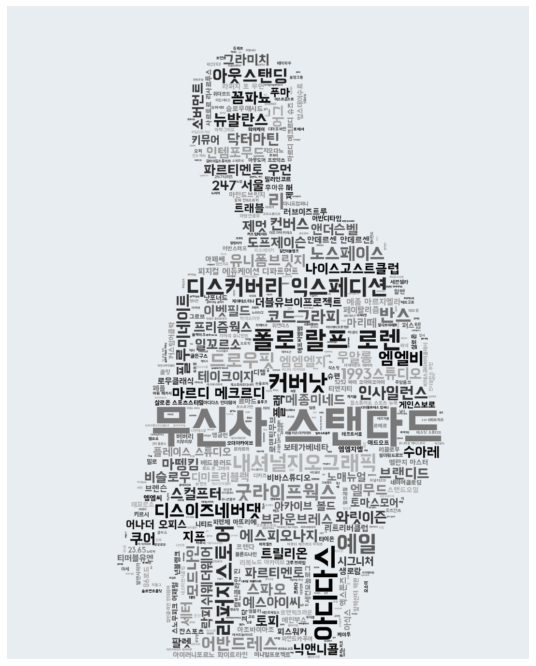

In [5]:
# ======================================================> 데이터 시각화
# 랭킹페이지에 올라간 상품 개수에 따른 워드클라우드 생성
brandName_dt = dict(musinsa_df['brand'].value_counts())
mask = np.array(Image.open('./images/musinsaMask.jpeg'))
def gray_color_func(word, font_size, position, orientation, random_state=None, **hwargs):
    return 'hsl(0, 0%%, %d%%)' % random.randint(0, 70)
wc = WordCloud(font_path='/Users/mac/Library/Fonts/BMHANNAPro.ttf', # 배민 한나체 Pro 사용
               background_color='#e8edf1', 
               mask=mask,
               max_words=len(brandName_dt),
               max_font_size=500,
               relative_scaling=0.5)
wordcloud = wc.generate_from_frequencies(brandName_dt)
plt.figure(figsize=(20, 12))
plt.imshow(wordcloud.recolor(color_func=gray_color_func, random_state=100), interpolation='bilinear')
plt.axis('off')
plt.show()
# plt.savefig('./output/musinsaWordCloud.png')

워드클라우드를 통해 어떤 브랜드가 많은 상품이 랭킹페이지에 올랐는지 간단하게 확인 가능하다.  

In [7]:
# 브랜드명과 랭킹페이지의 등록된 전체 상품의 수가 컬럼인 데이터프레임을 만들어준다.
brandCount = musinsa_df['brand'].value_counts().to_frame()
brandCount.rename(columns={'brand': 'count'}, inplace=True)
brandCount.index.name = 'brand'
brandCount.reset_index(inplace=True)
brandCount # 전체 브랜드와 상품의 수 데이터프레임

,brand,count
0,무신사 스탠다드,908
1,아디다스,207
2,폴로 랄프 로렌,167
3,커버낫,139
4,예일,137
...,...,...
910,연작,1
911,유제,1
912,선데이오프클럽,1
913,렉시,1


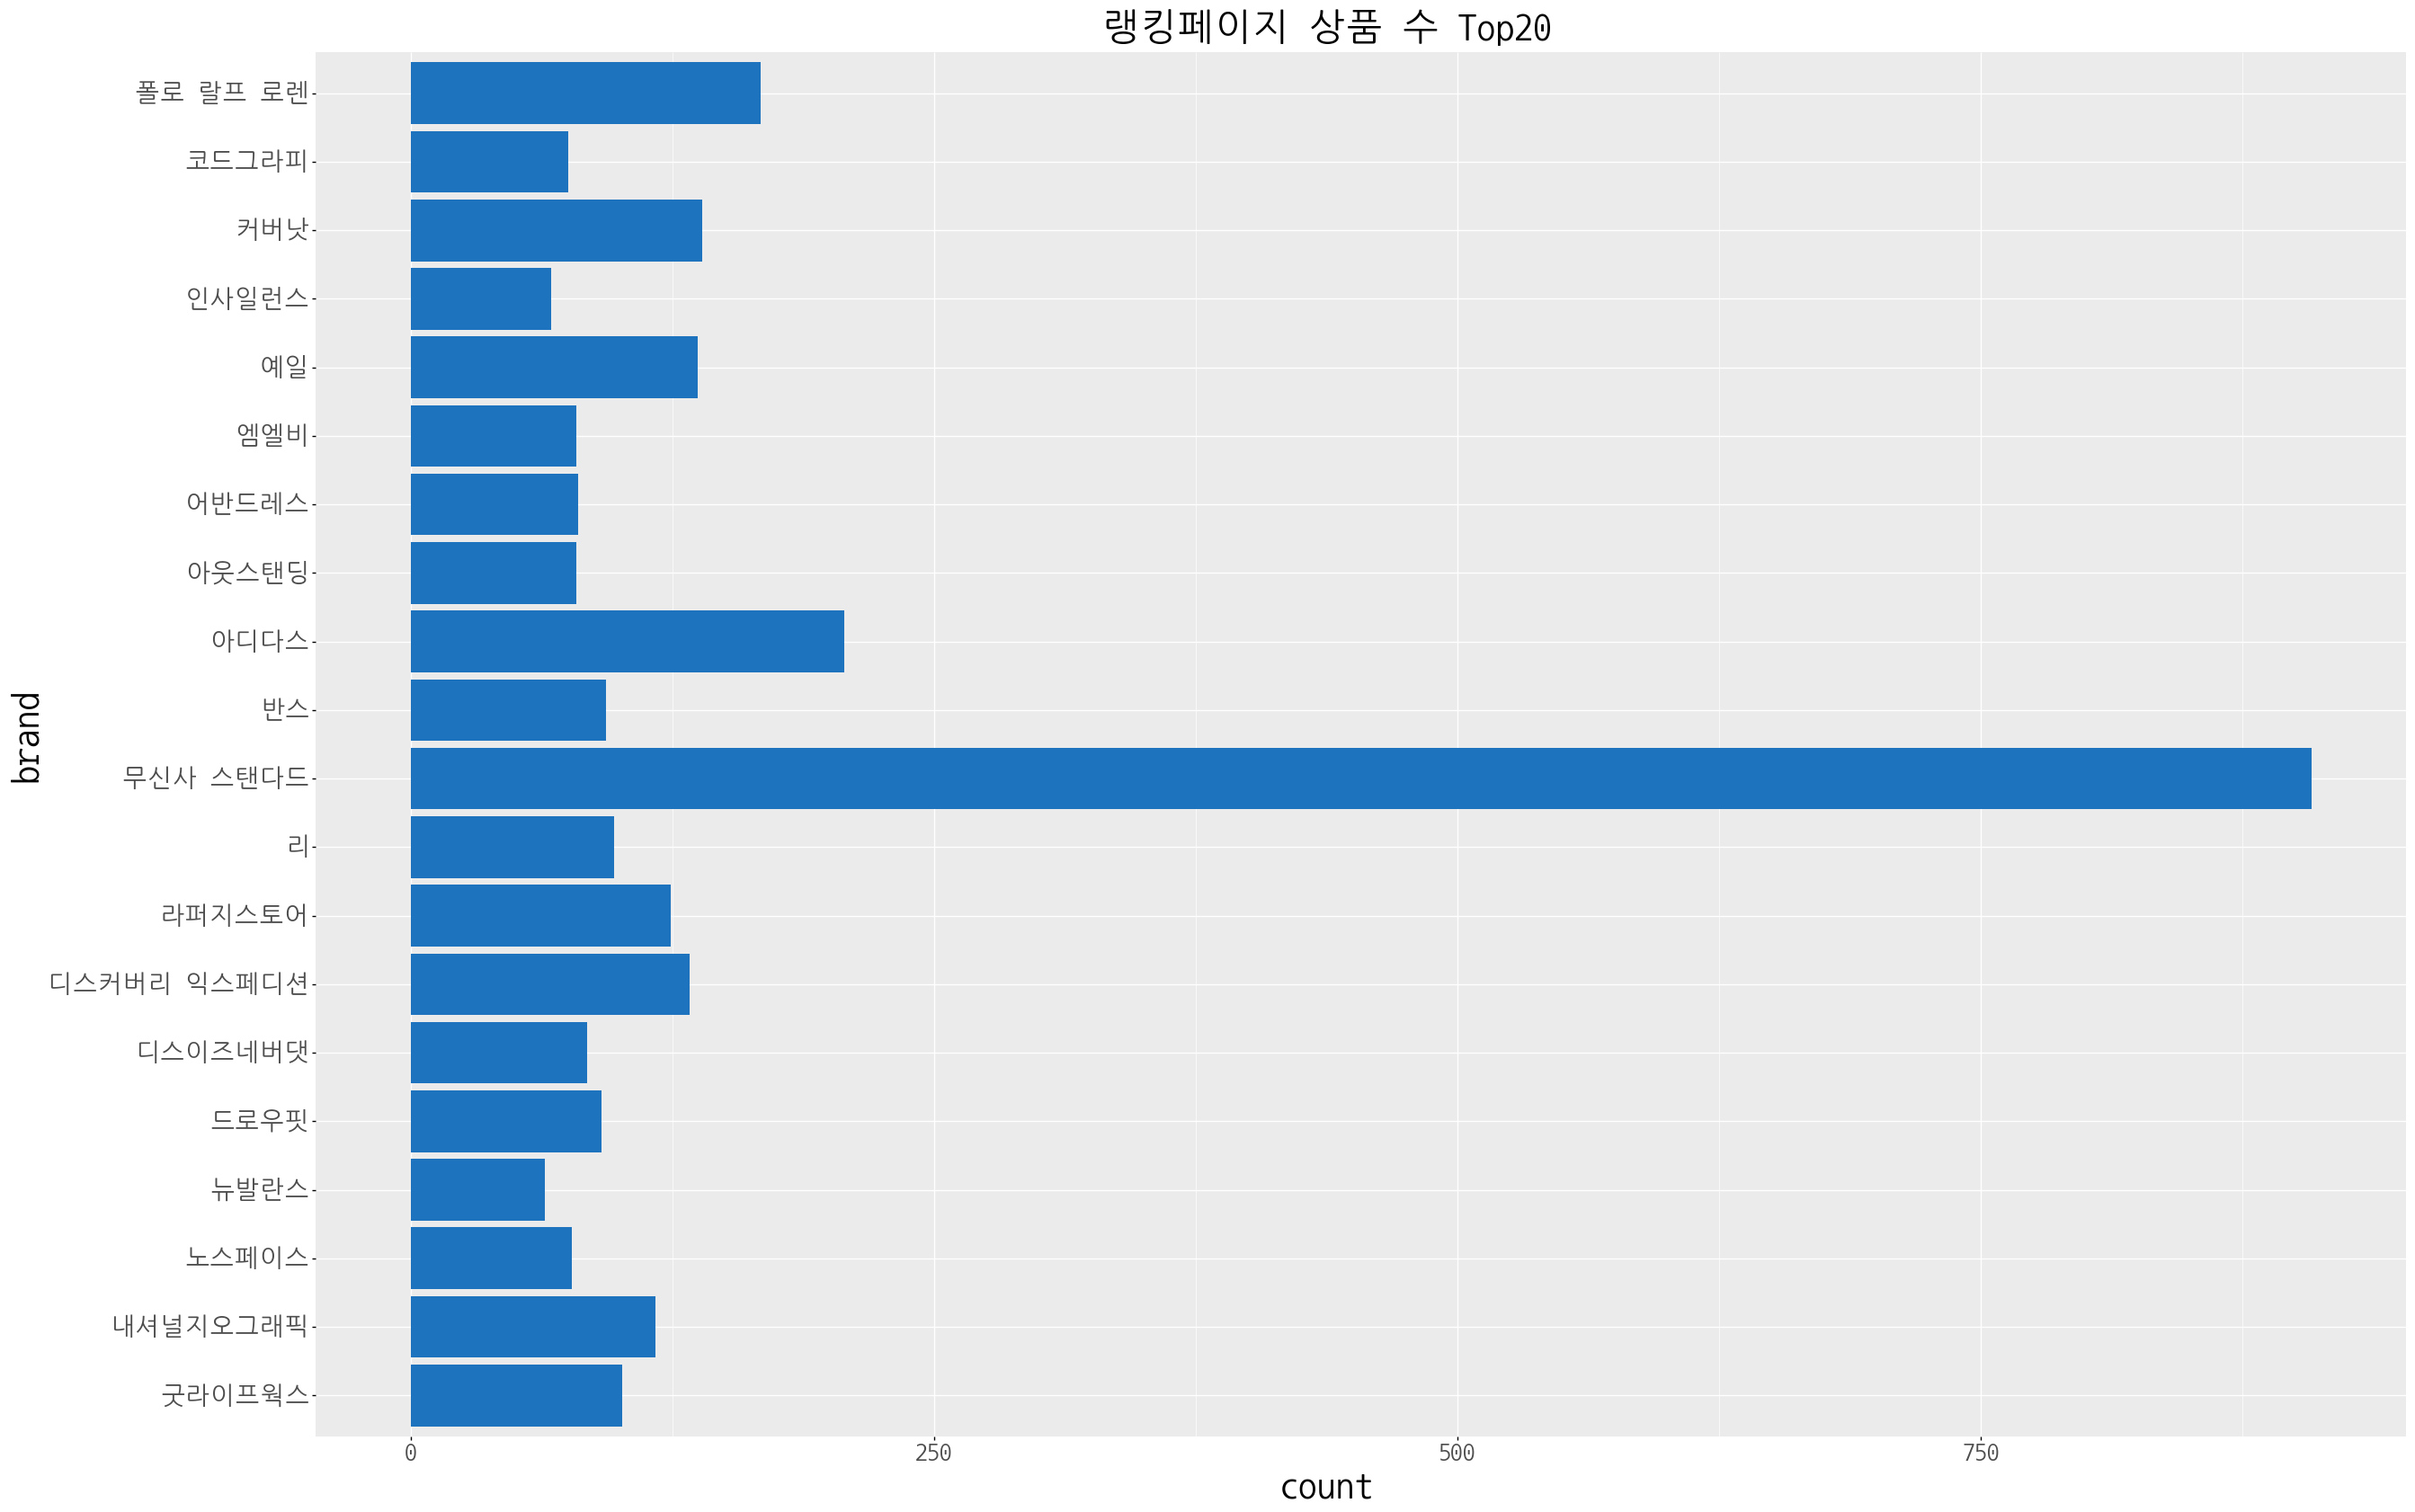

<ggplot: (-9223363272626786339)>

In [12]:
# 랭킹페이지 상품 수 Top 20
(
ggplot(brandCount.head(20), aes(x='brand', y='count'))
    + geom_bar(stat='identity', position='dodge', fill='#1e73be')
    + coord_flip()
    + ggtitle('랭킹페이지 상품 수 Top20')
    + theme(text=element_text(family='NanumGothicCoding', size=20), figure_size=(30, 20), title=element_text(size=30))
)

무신사 스탠다드의 상품수가 타 브랜드의 비해 압도적으로 많은 것을 확인할 수 있다.

# 파이차트를 통한 비율 확인

In [13]:
# 무신사 스탠다드를 제외한 top20권의 브랜드들을 상위권 브랜드로 분류해준다.
topRank = brandCount.head(20)[brandCount['brand'] != '무신사 스탠다드']
topRank_insert = {'brand': '상위권 브랜드', 'count': topRank['count'].sum()}

# top31권 밖에 브랜드는 기타로 분류해준다.
etc = brandCount.tail(len(brandCount) - 20)
etc_insert = {'brand': '기타', 'count': etc['count'].sum()}

# 무신사 스탠다드, 상위권브랜드, 기타를 합쳐준다.
brandCount_final = brandCount[brandCount['brand'] == '무신사 스탠다드'].append(topRank_insert, ignore_index=True)
brandCount_final = brandCount_final.append(etc_insert, ignore_index=True)
brandCount_final 

,brand,count
0,무신사 스탠다드,908
1,상위권 브랜드,2011
2,기타,6081


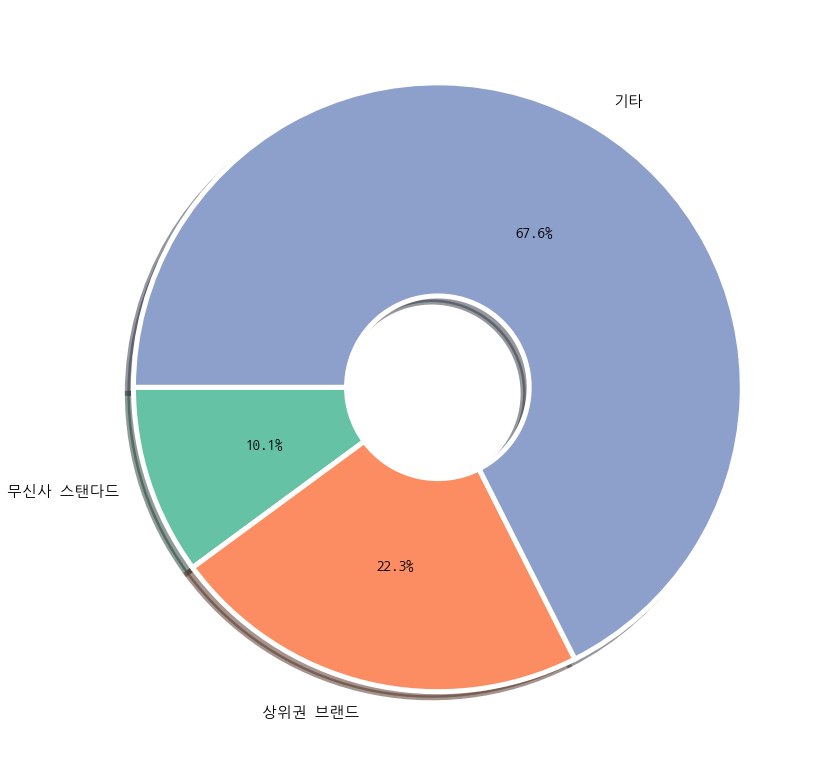

In [14]:
# brandOver60 데이터프레임으로 matplotlib의 파이차트를 만들어준다.
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

plt.figure(figsize=(14, 14))
(
plt.pie(
    x = brandCount_final['count'],
    labels=brandCount_final['brand'],
    autopct='%.1f%%',
    startangle=180,
    shadow=True,
    colors=sns.color_palette('Set2'),
    wedgeprops=wedgeprops)
)
plt.show()

무신사 스탠다드까지 포함해서 상위권 브랜드의 상품이 랭킹페이지에서 굉장히 많은 비율을 가지고 있다는 걸 볼 수 있다.  

# 상위권 Top20 최소금액, 평균금액, 최대금액 비교

In [15]:
# 먼저 info() 함수를 사용해서 'price'와 'like'의 dtype이 int인지 확인한다.
musinsa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Rank    9000 non-null   object
 1   Good    9000 non-null   object
 2   brand   9000 non-null   object
 3   price   9000 non-null   object
 4   like    9000 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 351.7+ KB


In [16]:
# price의 dtype을 int로 변환시켜주는 과정
musinsa_df['price'] = musinsa_df['price'].str.replace(',', '')
musinsa_df['price'] = musinsa_df['price'].str.replace('원', '')
musinsa_df['price'] = musinsa_df['price'].astype(int)

In [17]:
musinsa_df

,Rank,Good,brand,price,like
0,1위,NJ1DN75A 남성 1996 에코 눕시 자켓,노스페이스,339000,29850
1,2위,베이직 푸퍼_SPJPC4TC11,스파오,63900,88608
2,3위,[무봉제]덕다운 심리스 미니멀 푸퍼 숏패딩_Black,라퍼지스토어,89900,52022
3,4위,RDS 롱 다운 파카 블랙,커버낫,223200,21031
4,5위,솔리드 무톤 자켓,도프제이슨,158000,36330
...,...,...,...,...,...
8995,8996위,오버사이즈 폴라 플리스 하이넥 재킷 [다크 그레이],무신사 스탠다드,30730,1301
8996,8997위,스탠다드 울 머플러 [GREY],247 서울,19900,646
8997,8998위,마스 울 히든버튼 뒤트임 롱 코트 블랙 MARS10BK,라뮤스튜디오,186800,185
8998,8999위,빅 사이즈 체크 머플러 [블랙/그레이],무신사 스탠다드,29900,4033


In [18]:
# describe() 함수를 사용해서 데이터 결과를 확인한다.
mss_des = musinsa_df.groupby(musinsa_df['brand']).describe()
mss_count_top20 = mss_des.sort_values(by=('price', 'count'), ascending=False).head(20) # 상위권 top10만 가져온다.

In [19]:
count_top20 = mss_count_top20.drop(labels=[('price', 'count'), ('price', 'std'), ('like', 'std')], axis=1)
count_top20

price                                                   \
                      mean      min       25%       50%       75%       max   
brand                                                                         
무신사 스탠다드      61780.792952   5890.0   29900.0   39900.0   69900.0  539890.0   
아디다스          85423.768116   9800.0   54150.0   79900.0  111200.0  299000.0   
폴로 랄프 로렌     176087.425150  21000.0   99000.0  167300.0  219000.0  903000.0   
커버낫           96346.043165  27300.0   55300.0   71100.0  119100.0  367200.0   
예일            63664.963504  19500.0   44500.0   59000.0   74500.0  174300.0   
디스커버리 익스페디션  237652.631579  39000.0  109000.0  189000.0  349000.0  750000.0   
라퍼지스토어        73002.419355  19900.0   43900.0   79800.0   99900.0  229000.0   
내셔널지오그래픽     236535.042735  49000.0  149000.0  239200.0  319000.0  570000.0   
굿라이프웍스        57245.544554  31000.0   42000.0   49800.0   63000.0  128000.0   
리             86398.453608  24500.0   62100.0   71200.0  111300.0  199200.0   
반스            78220.430108  19000.0   69000.0   79000.0   89000.0  169000.0   
드로우핏         132123.076923  23400.0   60750.0   68400.0  219000.0  367200.0   
디스이즈네버댓      114519.047619  27000.0   68000.0   89650.0  149400.0  293300.0   
어반드레스         46385.250000  17500.0   34500.0   39560.0   45372.5  112800.0   
엠엘비          110734.177215  23100.0   39000.0   66500.0  139000.0  379000.0   
아웃스탠딩        117632.911392  36500.0   63200.0   71200.0  181900.0  335750.0   
노스페이스        245631.168831  26100.0  134400.0  251100.0  339000.0  890000.0   
코드그라피         86549.333333  39900.0   69900.0   89900.0   99900.0  200000.0   
인사일런스        226820.895522  32000.0  195000.0  233000.0  279000.0  337000.0   
뉴발란스         197281.250000  99000.0  109000.0  129000.0  279000.0  599000.0   

              like                                                            
             count          mean    min      25%     50%       75%       max  
brand                                                                         
무신사 스탠다드     908.0   4890.030837   29.0   838.00  2015.5   4977.75   97584.0  
아디다스         207.0   5319.618357  159.0   769.50  2095.0   5521.50   66694.0  
폴로 랄프 로렌     167.0   1855.107784   54.0   263.50   523.0   1785.50   26336.0  
커버낫          139.0   8853.848921  133.0   816.50  2422.0  10663.00  129493.0  
예일           137.0   7982.138686  332.0  1319.00  2489.0   8676.00   72626.0  
디스커버리 익스페디션  133.0   1973.323308   37.0   301.00   621.0   1619.00   32420.0  
라퍼지스토어       124.0  12069.161290  525.0  2000.50  3921.0  11773.75  109887.0  
내셔널지오그래픽     117.0   1504.470085   80.0   322.00   598.0   1506.00   24630.0  
굿라이프웍스       101.0   7149.009901  332.0  1563.00  2964.0   6723.00   60848.0  
리             97.0  10398.783505  210.0  1300.00  2529.0  13938.00  105966.0  
반스            93.0   6704.870968  148.0   954.00  2463.0   8744.00   54293.0  
드로우핏          91.0   5789.307692  301.0  1308.50  2568.0   6980.50   37773.0  
디스이즈네버댓       84.0   4130.523810  254.0   795.75  1449.0   3332.75   43217.0  
어반드레스         80.0   6817.725000  299.0  2425.50  4313.0   8474.50   49293.0  
엠엘비           79.0   9312.075949  141.0  1505.00  3044.0  11145.00   76541.0  
아웃스탠딩         79.0   2818.772152  301.0   878.50  1566.0   3460.00   18555.0  
노스페이스         77.0   3224.506494   84.0   494.00  1102.0   2865.00   44900.0  
코드그라피         75.0  10981.520000  196.0  2970.50  5101.0  14229.50   79978.0  
인사일런스         67.0   2567.656716  153.0   560.50   792.0   1836.50   21313.0  
뉴발란스          64.0   2435.046875  146.0   636.75  1214.0   3447.50   15122.0

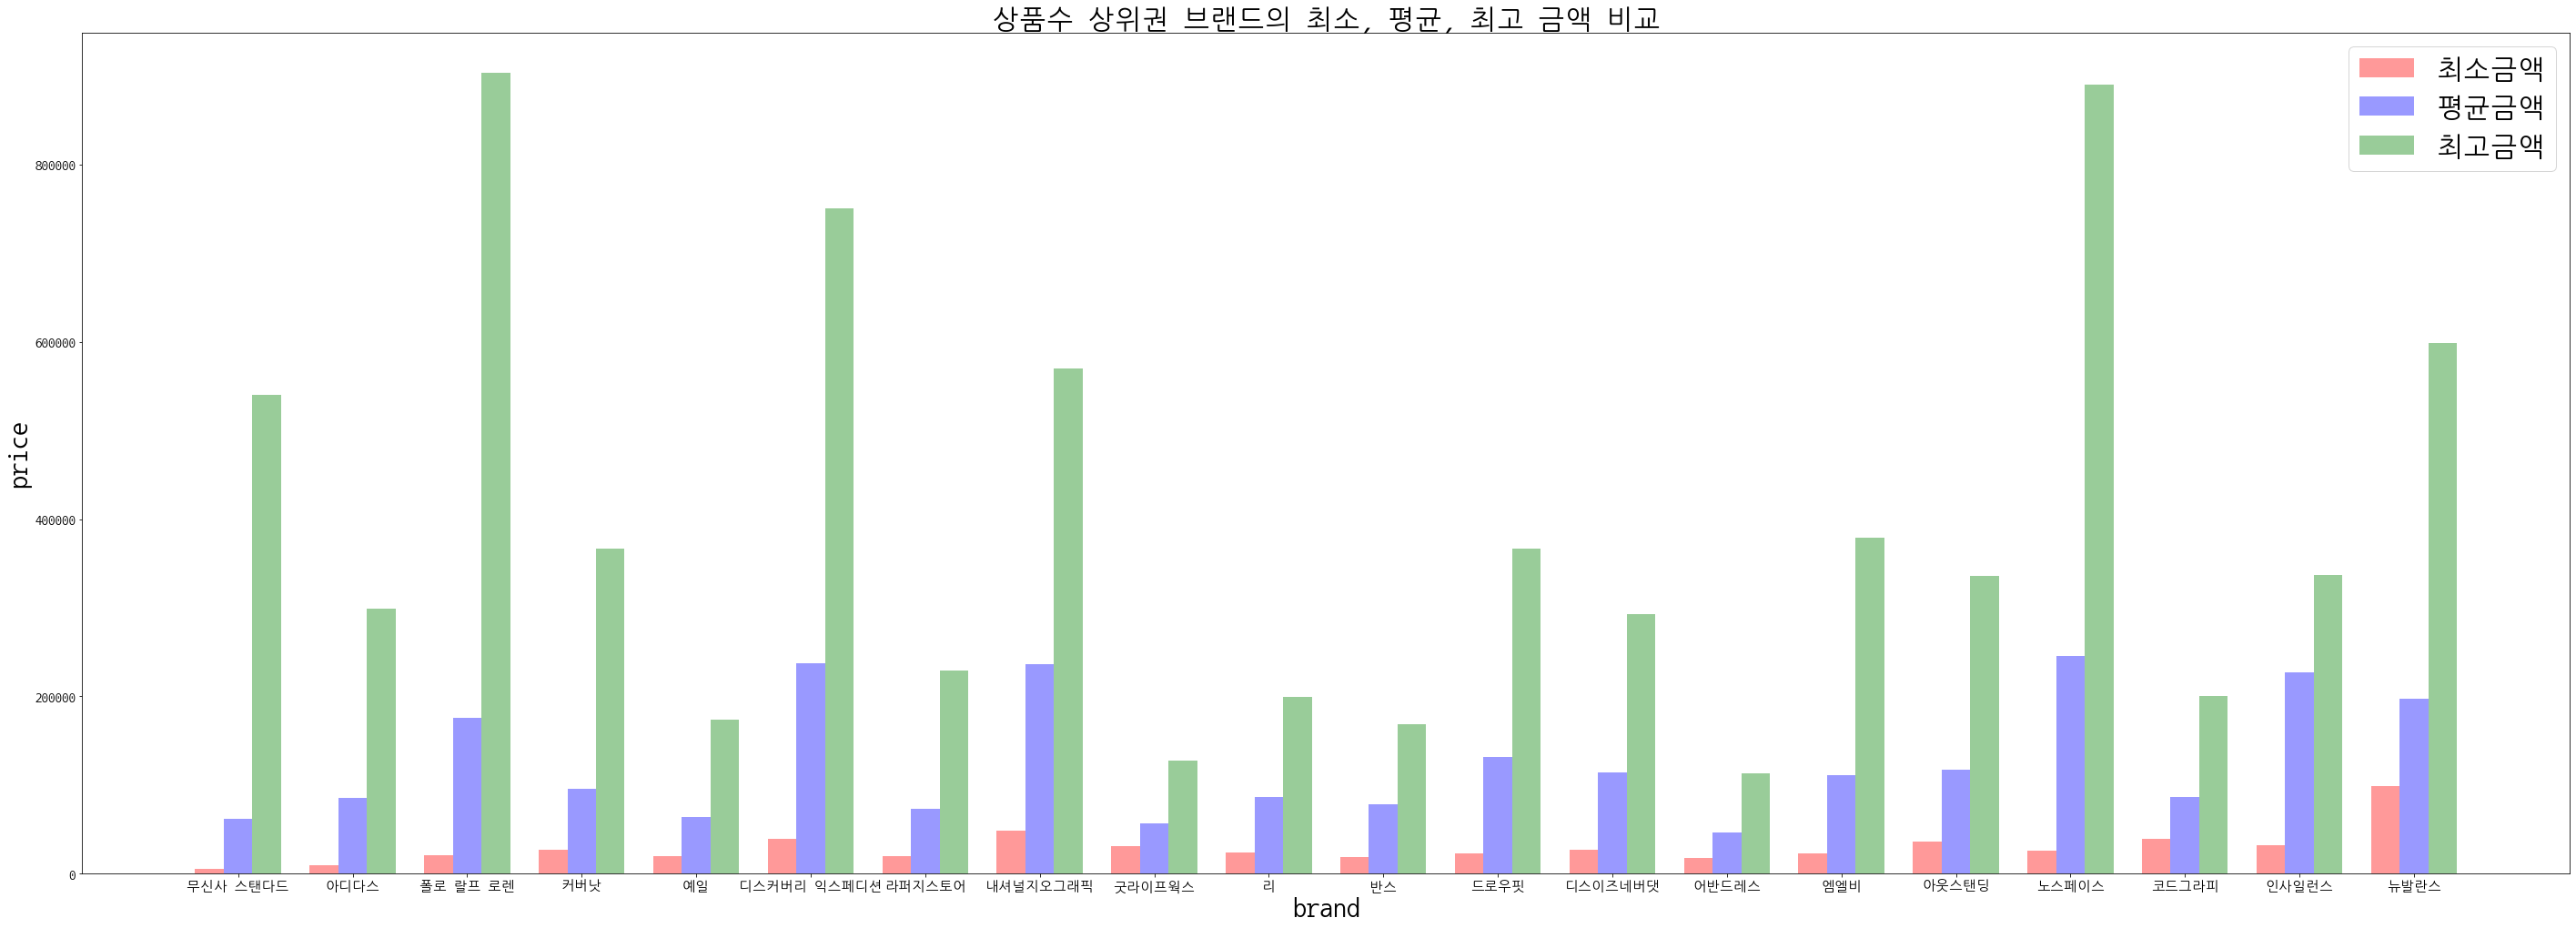

In [20]:
# plt.bar를 이용하여 다중 막대그래프를 통해 최소, 평균, 최고금액을 비교한다.
df = count_top20
fig, ax = plt.subplots(figsize=(49,17))
bar_width = 0.25

index = np.arange(len(df))

b1 = plt.bar(index, df['price']['min'], bar_width, alpha=0.4, color='red', label='최소금액')
b2 = plt.bar(index + bar_width, df['price']['mean'], bar_width, alpha=0.4, color='blue', label='평균금액')
b3 = plt.bar(index + 2 * bar_width, df['price']['max'], bar_width, alpha=0.4, color='green', label='최고금액')

plt.xticks(np.arange(bar_width, len(df) + bar_width, 1), df.index)

plt.xlabel('brand', size = 30)
plt.ylabel('price', size = 30)
plt.title('상품수 상위권 브랜드의 최소, 평균, 최고 금액 비교', size = 30)
plt.legend(fontsize=30)
plt.show()

최소, 최대금액의 차이가 커서 잘 확인이 안되므로 25%, 50%, 75%로 비교하도록 한다.

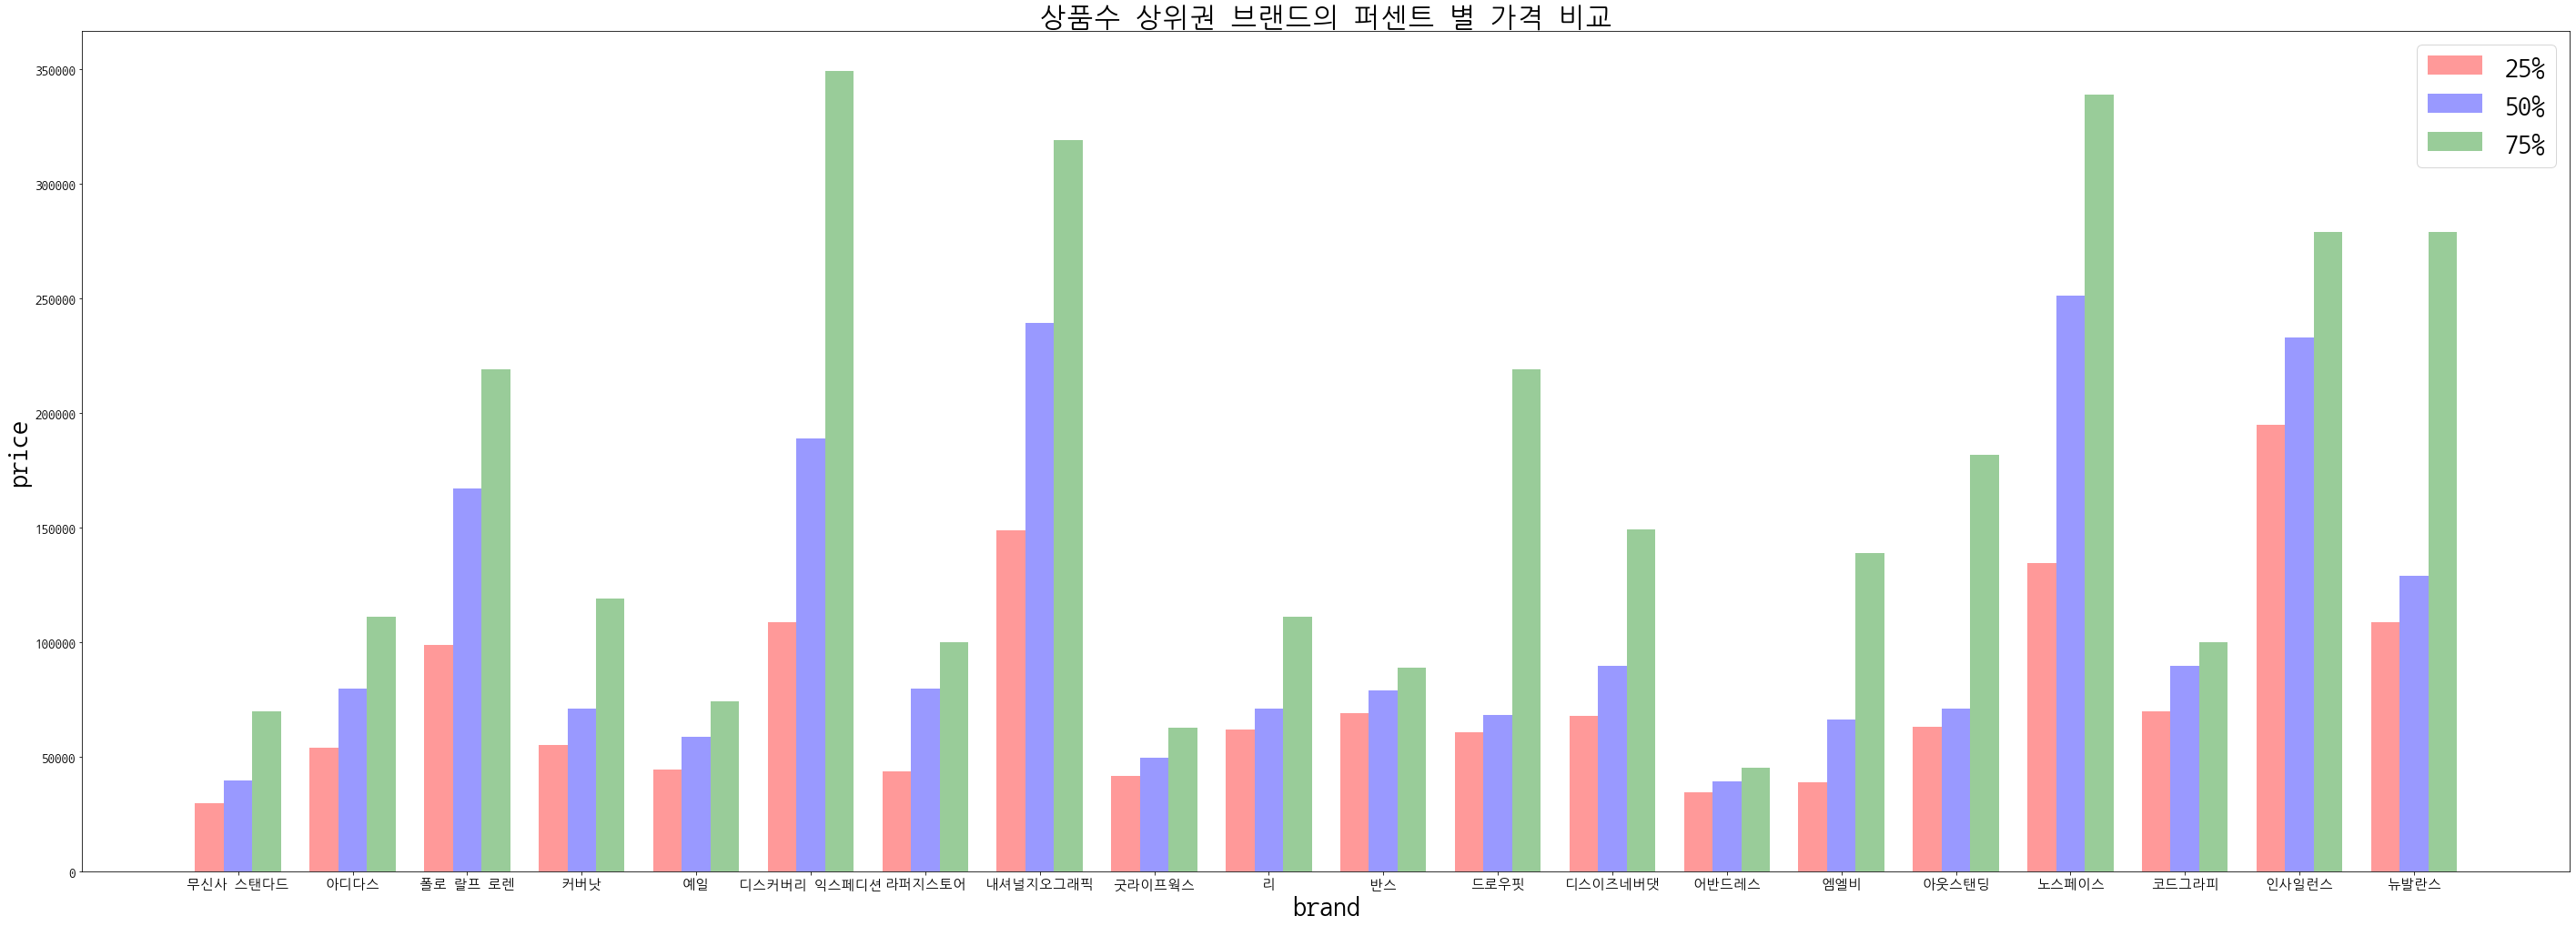

In [22]:
# plt.bar를 이용하여 다중 막대그래프를 통해 25%, 50%, 75% 가격을 비교한다.
fig, ax = plt.subplots(figsize=(49,17))
bar_width = 0.25

index = np.arange(len(df))

b1 = plt.bar(index, df['price']['25%'], bar_width, alpha=0.4, color='red', label='25%')
b2 = plt.bar(index + bar_width, df['price']['50%'], bar_width, alpha=0.4, color='blue', label='50%')
b3 = plt.bar(index + 2 * bar_width, df['price']['75%'], bar_width, alpha=0.4, color='green', label='75%')

plt.xticks(np.arange(bar_width, len(df) + bar_width, 1), df.index)

plt.xlabel('brand', size = 30)
plt.ylabel('price', size = 30)
plt.title('상품수 상위권 브랜드의 퍼센트 별 가격 비교', size = 30)
plt.legend(fontsize=30)
plt.show()

무신사 스탠다드, 어반드레스는 가격대가 상위권에서 비교적 저렴한 편이고 유명 아웃도어 브랜드의 경우 전체적으로 가격대가 좀 있는 편이라는 것을 알 수 있다.

# 평균 좋아요 수가 많은 높은 Top20 브랜드 가격 비교

In [24]:
# 평균 좋아요 수 순서로 나열한다.
mss_likeMean = mss_des.sort_values(by=('like', 'mean'), ascending=False)
likeMean_top20 =  mss_likeMean.drop(labels=[('price', 'count'), ('price', 'std'), ('like', 'std')], axis=1).head(20)
likeMean_top20

price                                                like  \
                   mean      min      25%      50%      75%       max count   
brand                                                                         
후러브스아트     35100.000000  33900.0  33900.0  33900.0  36900.0   36900.0   5.0   
바이모스       32000.000000  32000.0  32000.0  32000.0  32000.0   32000.0   1.0   
토앤토        44000.000000  44000.0  44000.0  44000.0  44000.0   44000.0   2.0   
퍼블릭아이콘     32000.000000  32000.0  32000.0  32000.0  32000.0   32000.0   2.0   
핍스         44250.000000  39500.0  41875.0  44250.0  46625.0   49000.0   2.0   
하 아카이브     90400.000000  59000.0  76000.0  79000.0  79000.0  159000.0   5.0   
노비오        33300.000000  33300.0  33300.0  33300.0  33300.0   33300.0   2.0   
굿하비클럽      31200.000000  31200.0  31200.0  31200.0  31200.0   31200.0   1.0   
오앤에이       59000.000000  59000.0  59000.0  59000.0  59000.0   59000.0   1.0   
우포스        69000.000000  69000.0  69000.0  69000.0  69000.0   69000.0   2.0   
오드스튜디오     59566.666667  25800.0  49950.0  53800.0  72950.0   96000.0   6.0   
가까이 유니언즈   38511.111111  36400.0  36400.0  36400.0  36400.0   54700.0   9.0   
논논         18900.000000  18900.0  18900.0  18900.0  18900.0   18900.0   1.0   
테일러 스튜디오   46900.000000  46900.0  46900.0  46900.0  46900.0   46900.0   1.0   
그루브라임      50022.222222  29000.0  41400.0  47400.0  59000.0   69000.0   9.0   
이에스엔       25925.000000  22600.0  22900.0  23000.0  26025.0   35100.0   4.0   
브렌슨        39400.000000  21900.0  26400.0  39900.0  48900.0   69900.0  22.0   
쇼브오프       26000.000000  26000.0  26000.0  26000.0  26000.0   26000.0   1.0   
토피         39588.888889  34000.0  39000.0  39000.0  39000.0   89000.0  45.0   
다이아몬드 레이라  55514.285714  49000.0  51000.0  51000.0  58800.0   69000.0   7.0   

                                                                         
                   mean      min       25%      50%       75%       max  
brand                                                                    
후러브스아트     65757.000000   5347.0  22773.00  28526.0  57652.00  214487.0  
바이모스       44933.000000  44933.0  44933.00  44933.0  44933.00   44933.0  
토앤토        38040.000000  33540.0  35790.00  38040.0  40290.00   42540.0  
퍼블릭아이콘     34647.500000  13775.0  24211.25  34647.5  45083.75   55520.0  
핍스         33053.000000   7458.0  20255.50  33053.0  45850.50   58648.0  
하 아카이브     32528.600000   3956.0  15092.00  17612.0  31511.00   94472.0  
노비오        28172.500000  20139.0  24155.75  28172.5  32189.25   36206.0  
굿하비클럽      27043.000000  27043.0  27043.00  27043.0  27043.00   27043.0  
오앤에이       26013.000000  26013.0  26013.00  26013.0  26013.00   26013.0  
우포스        25599.500000   5384.0  15491.75  25599.5  35707.25   45815.0  
오드스튜디오     24122.666667   2609.0   5498.25  10987.5  36531.00   71438.0  
가까이 유니언즈   23445.888889    952.0   4105.00   5030.0  16856.00  131895.0  
논논         22891.000000  22891.0  22891.00  22891.0  22891.00   22891.0  
테일러 스튜디오   22048.000000  22048.0  22048.00  22048.0  22048.00   22048.0  
그루브라임      21585.111111    760.0   2357.00   9214.0  46333.00   58695.0  
이에스엔       21547.250000   2080.0   7816.75  13853.5  27584.00   56402.0  
브렌슨        20689.227273    708.0   2716.50   9780.5  25826.25   85879.0  
쇼브오프       20605.000000  20605.0  20605.00  20605.0  20605.00   20605.0  
토피         20403.022222    942.0   2645.00   7556.0  18825.00  163756.0  
다이아몬드 레이라  20171.857143    949.0   7983.50  14302.0  30738.00   48509.0

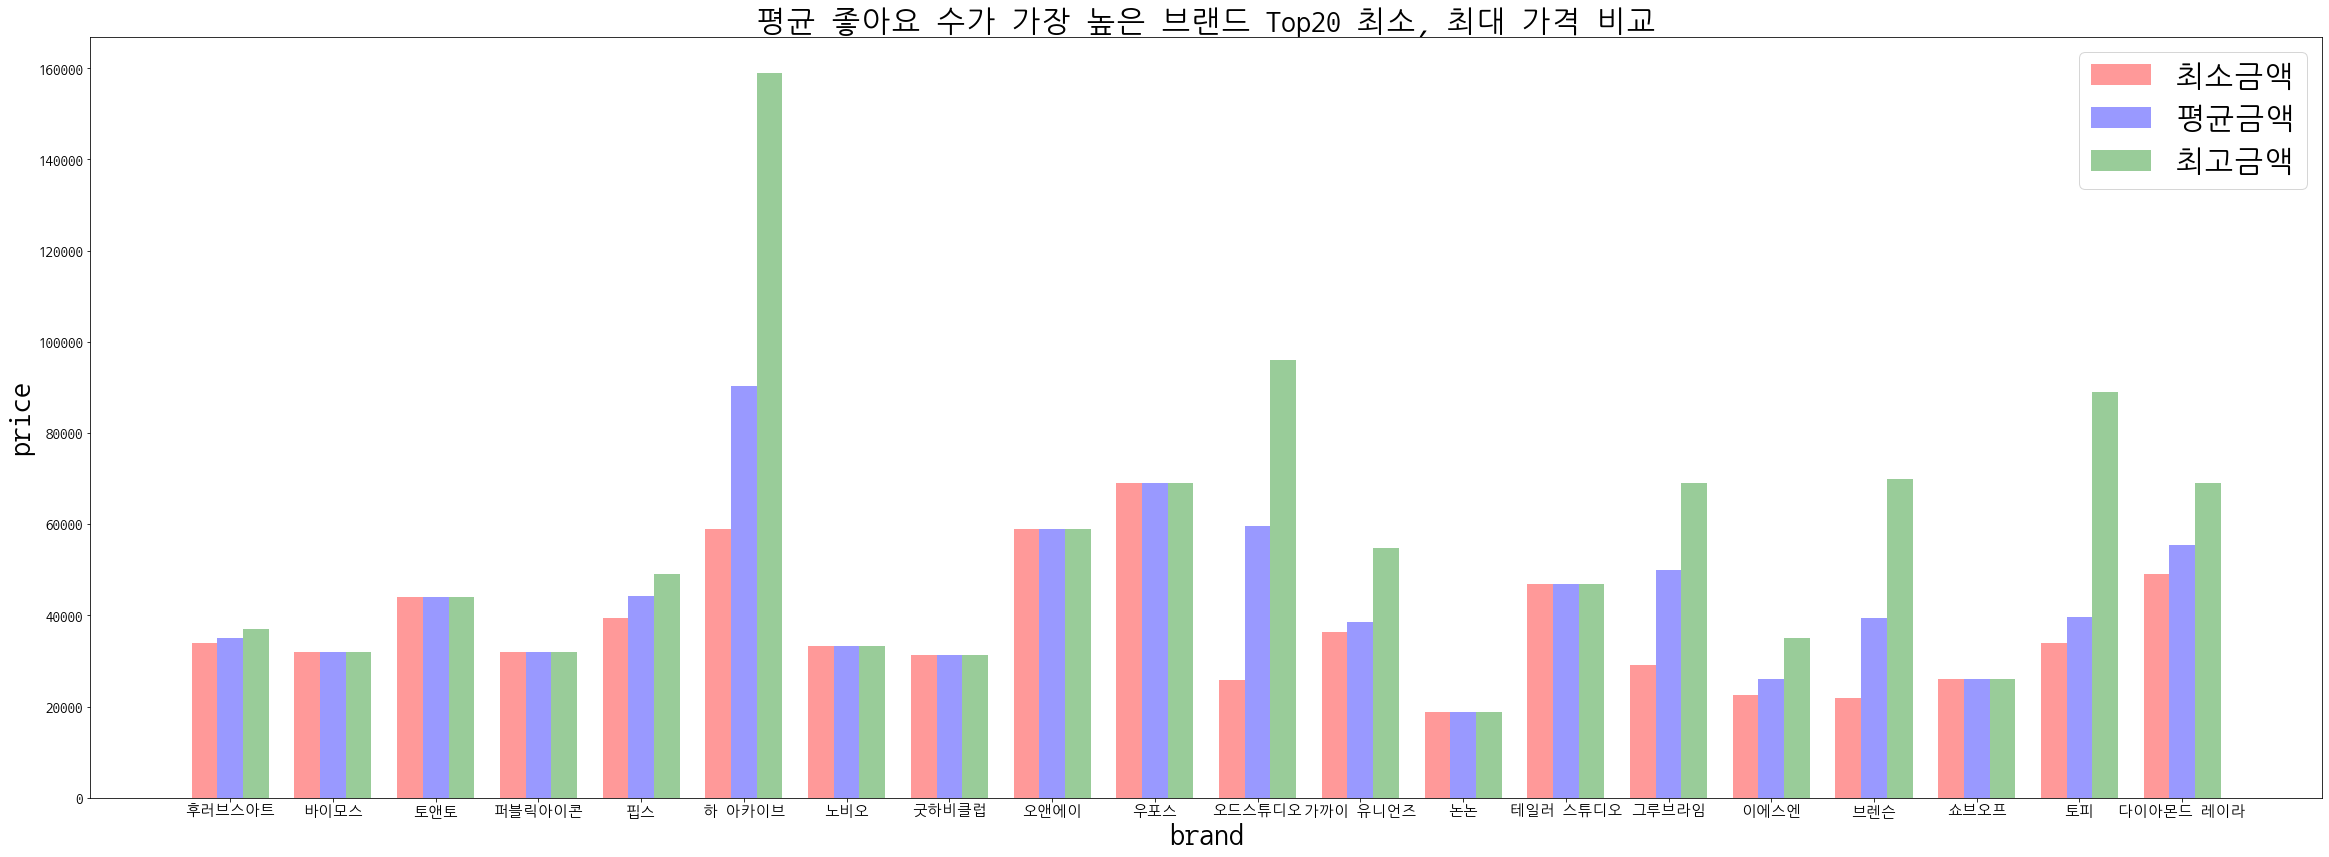

In [27]:
df = likeMean_top20
fig, ax = plt.subplots(figsize=(40,14))
bar_width = 0.25

index = np.arange(len(df))

b1 = plt.bar(index, df['price']['min'], bar_width, alpha=0.4, color='red', label='최소금액')
b2 = plt.bar(index + bar_width, df['price']['mean'], bar_width, alpha=0.4, color='blue', label='평균금액')
b3 = plt.bar(index + 2 * bar_width, df['price']['max'], bar_width, alpha=0.4, color='green', label='최고금액')

plt.xticks(np.arange(bar_width, len(df) + bar_width, 1), df.index)

plt.xlabel('brand', size = 30)
plt.ylabel('price', size = 30)
plt.title('평균 좋아요 수가 가장 높은 브랜드 Top20 최소, 최대 가격 비교', size = 30)
plt.legend(fontsize=30)
plt.show()

평균 좋아요 수가 높은 브랜드 중에서는 하 아카이프가 전체적인 가격대가 제일 높다라는 것을 알 수 있다.

# 가격대별 좋아요 수 비교

In [28]:
musinsa_df

,Rank,Good,brand,price,like
0,1위,NJ1DN75A 남성 1996 에코 눕시 자켓,노스페이스,339000,29850
1,2위,베이직 푸퍼_SPJPC4TC11,스파오,63900,88608
2,3위,[무봉제]덕다운 심리스 미니멀 푸퍼 숏패딩_Black,라퍼지스토어,89900,52022
3,4위,RDS 롱 다운 파카 블랙,커버낫,223200,21031
4,5위,솔리드 무톤 자켓,도프제이슨,158000,36330
...,...,...,...,...,...
8995,8996위,오버사이즈 폴라 플리스 하이넥 재킷 [다크 그레이],무신사 스탠다드,30730,1301
8996,8997위,스탠다드 울 머플러 [GREY],247 서울,19900,646
8997,8998위,마스 울 히든버튼 뒤트임 롱 코트 블랙 MARS10BK,라뮤스튜디오,186800,185
8998,8999위,빅 사이즈 체크 머플러 [블랙/그레이],무신사 스탠다드,29900,4033


In [29]:
musinsa_df['price_sort'] = ''

In [30]:
musinsa_df.loc[musinsa_df['price'] > 300000, 'price_sort'] = '30만원 이상'
musinsa_df.loc[musinsa_df['price'] <= 300000, 'price_sort'] = '20~30만원'
musinsa_df.loc[musinsa_df['price'] <= 200000, 'price_sort'] = '10~20만원'
musinsa_df.loc[musinsa_df['price'] <= 100000, 'price_sort'] = '5~10만원'
musinsa_df.loc[musinsa_df['price'] <= 50000, 'price_sort'] = '5만원 이하'

In [31]:
musinsa_df.value_counts('brand')

brand
무신사 스탠다드    908
아디다스        207
폴로 랄프 로렌    167
커버낫         139
예일          137
           ... 
롤링스튜디오        1
에이티티          1
에이지 그레이       1
에이딕트          1
쌤소나이트 레드      1
Length: 915, dtype: int64

In [32]:
topRank_2 = musinsa_df[musinsa_df['brand'] == count_top20.index[0]]
for i in range(1, 20):
    topRank_2 = topRank_2.append(musinsa_df[musinsa_df['brand'] == count_top20.index[i]])

In [33]:
topRank_2

,Rank,Good,brand,price,like,price_sort
7,8위,캐시미어 블렌드 오버사이즈 싱글 코트 [블랙],무신사 스탠다드,119925,34176,10~20만원
27,28위,다운 푸퍼 숏 패딩 재킷 [블랙],무신사 스탠다드,119900,18347,10~20만원
33,34위,캐시미어 블렌드 대디 숄더 싱글 롱 코트 [블랙],무신사 스탠다드,170910,15310,10~20만원
43,44위,헤비웨이트 속기모 테이퍼드 히든 밴딩 10부 슬랙스 [블랙],무신사 스탠다드,43900,10352,5만원 이하
51,52위,와이드 히든 밴딩 슬랙스 [블랙],무신사 스탠다드,35615,79603,5만원 이하
...,...,...,...,...,...,...
7625,7626위,NBPDCF725G / UXC72RF (GRAY),뉴발란스,139000,817,10~20만원
7952,7953위,NBP7CF758G / CM1600EL (GRAY),뉴발란스,169000,390,10~20만원
8033,8034위,NBPDCF721G / ML610TAA (GREY),뉴발란스,119000,897,10~20만원
8139,8140위,NBNPC4W902 / [연아다운] WOMEN 플라워 숏다운 (IVORY),뉴발란스,329000,220,30만원 이상


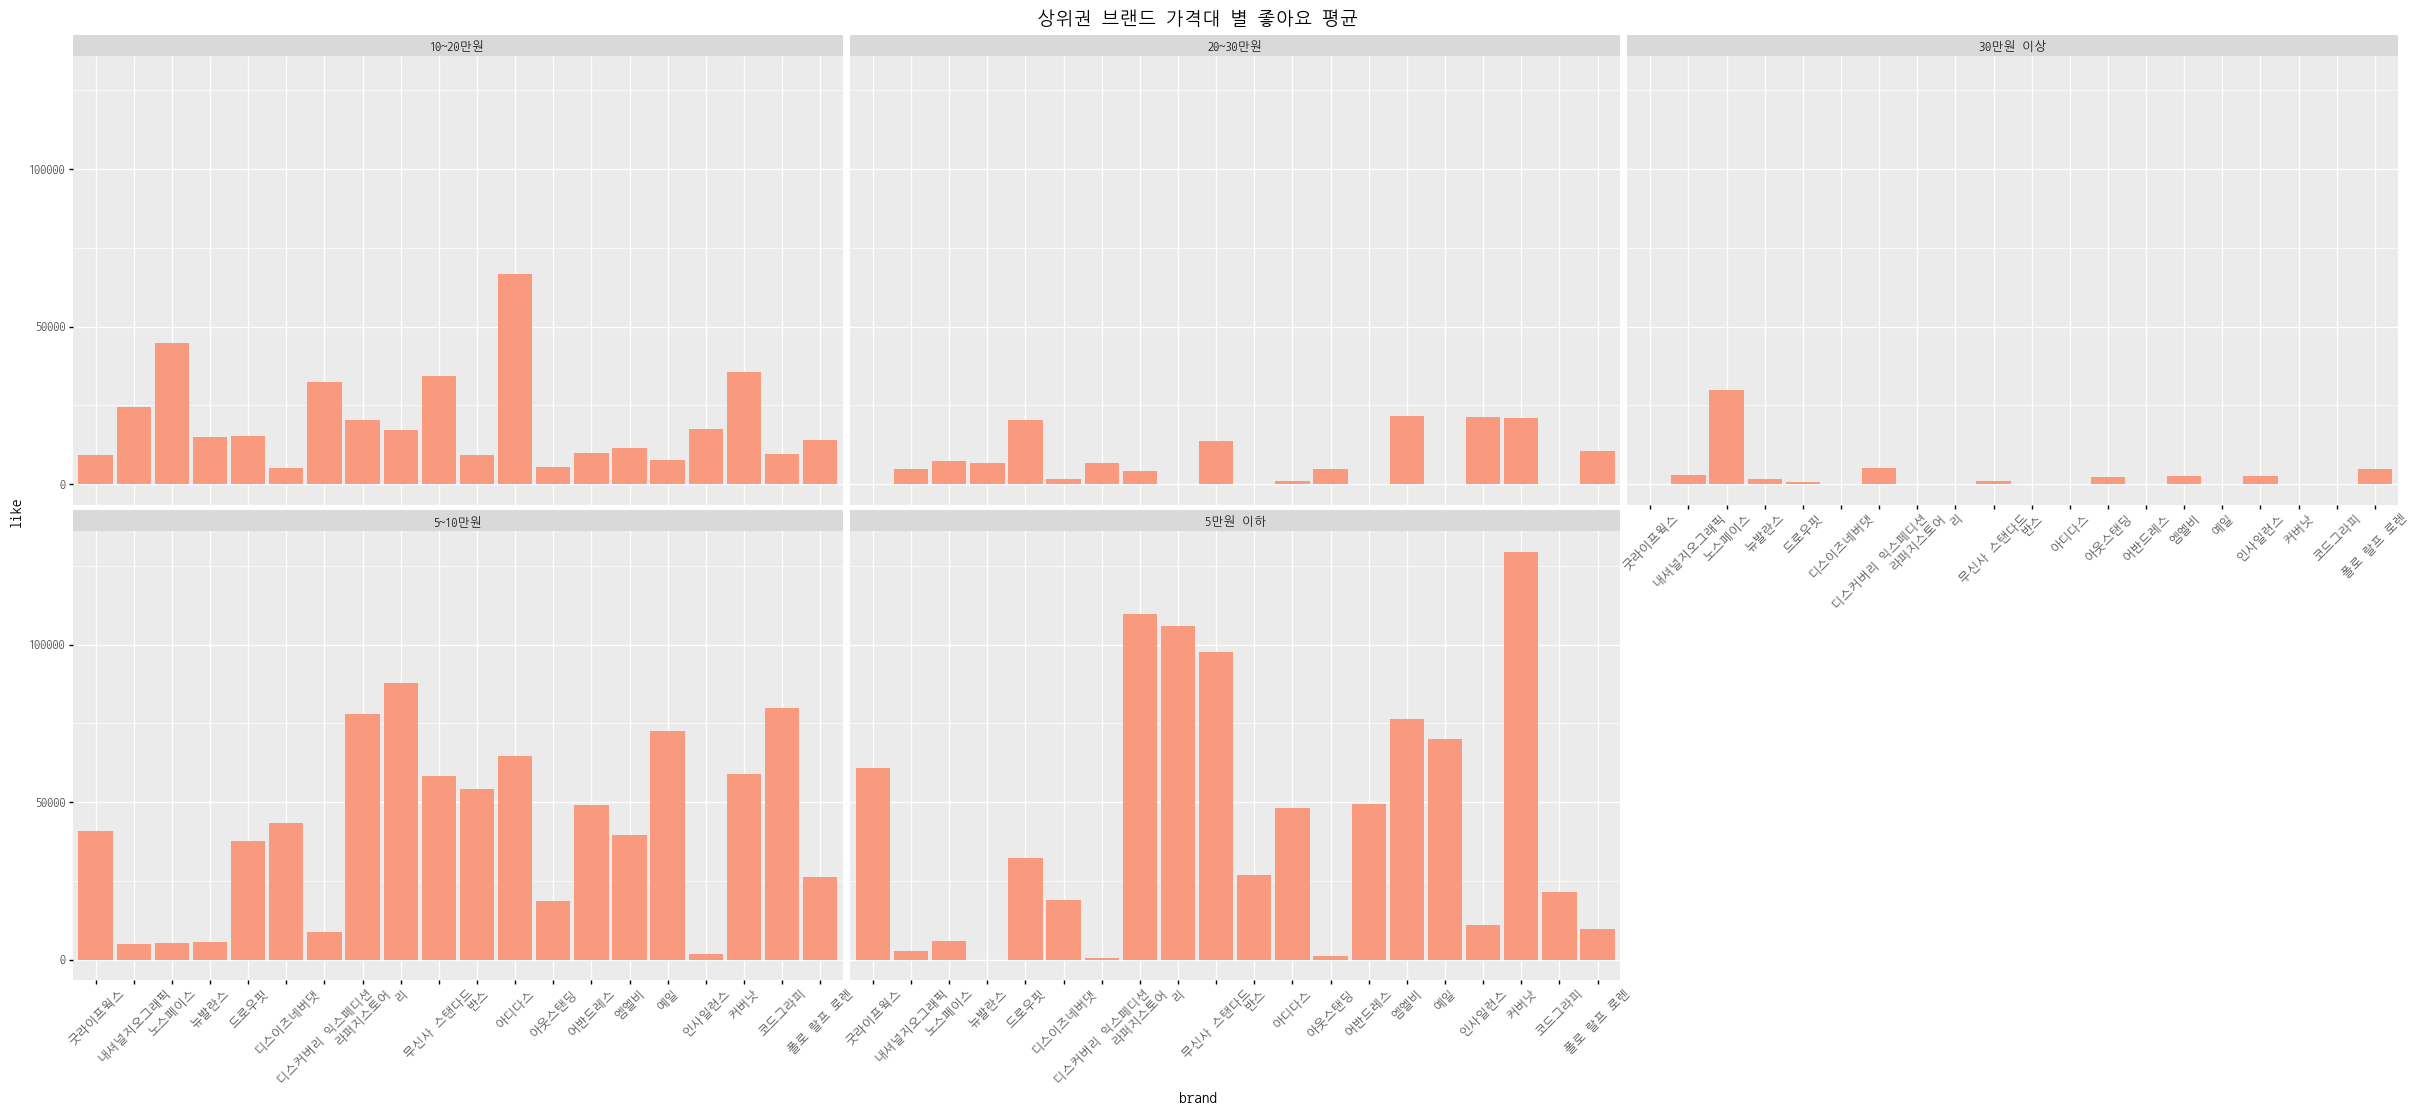

<ggplot: (-9223363272625255508)>

In [34]:
(
ggplot(topRank_2, aes(x='brand', y='like'))
    + geom_bar(stat='identity', position='dodge', fill='#f99a7f') 
    + facet_wrap('price_sort')
    + theme(text=element_text(family='NanumGothicCoding'), figure_size=(30, 12), axis_text_x=element_text(rotation=45)) 
    + ggtitle('상위권 브랜드 가격대 별 좋아요 평균')
)